In [202]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [203]:
R_mars = 3396.19 #km
mu_mars = 42828.3 #km /s

#LMO
h = 400 #km 
r_LMO = R_mars + h
theta_dot_LMO = np.sqrt(mu_mars/r_LMO**3) #rad/sec
t_LMO = 450 #s
angles_LMO = np.array([20,30,60])*np.pi/180 #Ω,i,θ(t_0), in radians
angles_LMO += np.array([0,0, theta_dot_LMO*t_LMO]) #Ω,i,θ(t), in radians

#GMO
r_GMO = 20424.2 #km
theta_dot_GMO = np.sqrt(mu_mars/r_GMO**3) #rad/s
t_GMO = 1150 #s
angles_GMO = np.array([0,0,250])*np.pi/180 #Ω,i,θ(t_0), in radians
angles_GMO += np.array([0,0, theta_dot_GMO*t_GMO]) #Ω,i,θ(t), in radians

#Spacecraft initial conditions
sigma_BN = np.array([0.3, -0.4, 0.5]) #initial attitude
w_BN_B = np.array([1.0, 1.75, -2.2])*np.pi/180 #initial body frame angular velocity WRT inertial frame
X0 = np.concatenate((sigma_BN, w_BN_B), axis=None)
I = np.array([[10,0,0],[0,5,0],[0,0,7.5]]) #inertia tensor

mission_mode = 'null'

In [204]:
def EAtoDCM313(t):
    """Insert 3-1-3 Euler angles in degrees and returns equivalent DCM"""

    a11 = math.cos(t[2])*math.cos(t[0]) - math.sin(t[2])*math.cos(t[1])*math.sin(t[0])
    a12 = math.cos(t[2])*math.sin(t[0]) + math.sin(t[2])*math.cos(t[1])*math.cos(t[0])
    a13 = math.sin(t[2])*math.sin(t[1])
    a21 = -math.sin(t[2])*math.cos(t[0]) - math.cos(t[2])*math.cos(t[1])*math.sin(t[0])
    a22 = -math.sin(t[2])*math.sin(t[0]) + math.cos(t[2])*math.cos(t[1])*math.cos(t[0])
    a23 = math.cos(t[2])*math.sin(t[1])
    a31 = math.sin(t[1])*math.sin(t[0])
    a32 = -math.sin(t[1])*math.cos(t[0])
    a33 = math.cos(t[1])

    DCM = np.array([[a11, a12, a13],
                    [a21, a22, a23],
                    [a31, a32, a33]])

    return DCM 


In [205]:
def orbitSimulator(r, angles):
    """Input position vector (orbit frame) and Euler angle sequence, outputs position vector and its
        derivative, both in inertial frame"""
    r_body = np.array([r, 0, 0])
    theta_body = np.array([0, r*np.sqrt(mu_mars/r**3), 0])

    rotation_mat = EAtoDCM313(angles).T
    r_inertial = rotation_mat@r_body.T
    r_dot_inertial = rotation_mat@theta_body.T

    return r_inertial, r_dot_inertial

In [206]:
#Task validation
orbitSimulator(r_LMO, angles_LMO)
orbitSimulator(r_GMO, angles_GMO)

(array([ -5399.15037424, -19697.64252078,      0.        ]),
 array([ 1.396568  , -0.38280117,  0.        ]))

In [207]:
def HN(t):
    """Rotation matrix from inertial to Hill/Orbit frame"""
    sigma = 20*np.pi/180
    i = 30*np.pi/180
    theta = (60*np.pi/180) + np.sqrt(mu_mars/r_LMO**3)*t

    return EAtoDCM313([sigma, i, theta])

In [208]:
#Task validation
print(HN(300))

[[-0.0464774   0.87414792  0.48343072]
 [-0.98417245 -0.12292213  0.12765086]
 [ 0.17101007 -0.46984631  0.8660254 ]]


In [209]:
def RsN():
    """Rotation matrix from inertial frame to sun-pointing frame"""
    return np.array([np.array([-1, 0, 0]), np.array([0, 0, 1]), np.array([0, 1, 0])])

In [210]:
#Task validation
print(RsN())

[[-1  0  0]
 [ 0  0  1]
 [ 0  1  0]]


In [211]:
def RnN(t):
    """Rotation matrix from inertial frame to nadir-pointing frame as function of time"""
    HRs = np.array([np.array([-1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, -1])])
    return HRs@HN(t)

In [212]:
#Task validation
print(RnN(330))

[[ 0.07258174 -0.87057754 -0.48664837]
 [-0.98259221 -0.1460794   0.11477527]
 [-0.17101007  0.46984631 -0.8660254 ]]


In [213]:
def N_w_RnN(t):
    """Angular velocity of nadir-pointing frame WRT inertial frame expressed in inertial frame coordinates,
        as function of time"""

    #w_RnN = w_RnH + w_HN = w_HN
    w_HN = np.array([0, 0, theta_dot_LMO])
    return HN(t).T@w_HN

In [214]:
#Task validation
print(N_w_RnN(330))

[ 0.00015131 -0.00041572  0.00076626]


In [215]:
def RcN(t):
    """Rotation matrix from inertial frame to communication frame as function of time"""

    #RcN = NRc.T = [[Nr1],[Nr2], [Nr3]]

    angles_LMO = np.array([20,30,60])*np.pi/180 #Ω,i,θ(t_0), in radians
    angles_LMO += np.array([0,0, theta_dot_LMO*t]) #Ω,i,θ(t), in radians

    angles_GMO = np.array([0,0,250])*np.pi/180 #Ω,i,θ(t_0), in radians
    angles_GMO += np.array([0,0, theta_dot_GMO*t]) #Ω,i,θ(t), in radians

    N_r_GMO, _ = orbitSimulator(r_GMO, angles_GMO)
    N_r_LMO, _ = orbitSimulator(r_LMO, angles_LMO)

    delta_r = N_r_GMO - N_r_LMO

    n_3 = np.array([0,0,1])
    N_r1 = -delta_r/np.linalg.norm(delta_r)
    N_r2 = np.cross(delta_r, n_3)/np.linalg.norm(np.cross(delta_r, n_3))
    N_r3 = np.cross(N_r1, N_r2)

    return np.array([N_r1, N_r2, N_r3])

In [216]:
#Task validation
print(RcN(330))

[[ 0.26547539  0.96092816  0.07835742]
 [-0.96389181  0.26629415  0.        ]
 [-0.02086612 -0.07552807  0.99692533]]


In [217]:
def N_w_RcN(t):
    """Angular velocity of communication frame WRT inertial frame expressed in inertial frame coordinates,
        as function of time"""

    dt = 0.1
    DCM = RcN(t)
    DCM_next = RcN(t+dt)
    DCMdot = (DCM_next.T-DCM.T)/0.1

    omega_matrix = DCMdot@DCM
    w = np.array([])
    w = np.append(w, omega_matrix[2][1])
    w = np.append(w, omega_matrix[0][2])
    w = np.append(w, -1*omega_matrix[0][1])

    return w

In [218]:
#Task validation
print(N_w_RcN(330))

[ 1.97803453e-05 -5.46433272e-06  1.91299159e-04]


In [219]:
def tilde(sigma):
    '''
    Computes the tilde matrix com a given vector
    ---------
    Arguments:
        sigma {np.array} -- general vector of dimension 3
    ---------
    Returns:
        (3,3) np.array -- tilde matrix
    '''
    sigma = np.squeeze(sigma)
    return np.array([[0, -sigma[2],sigma[1]],
                     [sigma[2], 0, -sigma[0]],
                     [-sigma[1], sigma[0], 0]
                     ])

In [220]:
def sigma_to_dcm(sigma):
    '''
    Computes the Direct Cosine Matrix from a set of Modified Rodrigues Parameters
    ----------
    Arguments:
        sigma {np.array} -- MRP
    ----------
    Returns:
        (3,3) np.array -- Direct Cosine Matrix
    '''
    sigma_squared = np.inner(sigma, sigma)
    DCM = np.eye(3) + (8*tilde(sigma)@tilde(sigma) - 4*(1 - sigma_squared)*tilde(sigma) )/ (1 + sigma_squared)**2
    return DCM

In [221]:
def dcm_to_sigma(matrix):
    '''
    Computes the set of Modified Rodrigues Parameters from a Direct Cosine Matrix
    ----------
    Arguments:
        (3,3) np.array -- Direct Cosine Matrix
    ----------
    Returns:
        sigma {np.array} -- MRP
    '''
    zeta = np.sqrt(np.trace(matrix) + 1)
    constant = 1 / (zeta**2 + 2 * zeta)
    s1 = constant * (matrix[1, 2] - matrix[2, 1])
    s2 = constant * (matrix[2, 0] - matrix[0, 2])
    s3 = constant * (matrix[0, 1] - matrix[1, 0])
    return np.array([s1, s2, s3])

In [222]:
def state(t, sigmaBN, B_w_BN, RN, N_w_RN):
    """Returns state error: Computes sigmaBR, B_w_BR"""

    NR = RN.T
    BN = sigma_to_dcm(sigmaBN)
    BR = BN@NR
    sigmaBR = dcm_to_sigma(BR)

    if np.linalg.norm(sigmaBR) > 1:
        norm = np.linalg.norm(sigmaBR)**2
        for param in sigmaBR:
            param = -param/norm

    B_w_BR = B_w_BN - BN@N_w_RN

    return sigmaBR, B_w_BR

In [223]:
#Task validation
print(state(0, sigma_BN, w_BN_B, RsN(), [0, 0, 0]))

(array([-0.77542077, -0.47386825,  0.04307893]), array([ 0.01745329,  0.03054326, -0.03839724]))


In [224]:
def control(t, sigma_BN, B_w_BN):

    """Implementing the PD control law, with gains computed from the assignment specifications
        Takes in time, sigmas and omegas, outputs control vector depending on mission mode"""

    global mission_mode
    K = 0.00556
    P = 0.16667

    if mission_mode == 'null':
        return np.array([0, 0, 0])

    elif mission_mode == 'const':
        return np.array([0.01, -0.01, 0.02])

    elif mission_mode == 'sun':
        sigma, omega = state(t, sigma_BN, B_w_BN, RsN(), np.array([0, 0, 0]))
        return -K*sigma - P*omega

    elif mission_mode == 'nadir':
        sigma, omega = state(t, sigma_BN, B_w_BN, RnN(t), N_w_RnN(t))
        return -K*sigma - P*omega

    elif mission_mode == 'comm':
        sigma, omega = state(t, sigma_BN, B_w_BN, RcN(t), N_w_RcN(t))
        return -K*sigma - P*omega


In [225]:
def B_w_BN_dot(B_w_BN, u):
    """Computes derivative of angular velocity of body frame WRT inertial frame, expressed in body frame coordiantes"""
    return np.linalg.inv(I)@(-tilde(B_w_BN)@I@B_w_BN + u)

In [226]:
def sigma_dot(sigma, w):
    '''
    Computes the time derivative of the MRP
    ----------
    Arguments:
        sigma {np.array} -- MRP
        w {np.array} -- angular velocity
    ----------
    Returns:
        (3,1) np.array -- sigma_dot
    '''

    B = 0.25 * np.dot(((1 - np.dot(sigma, sigma)) * np.eye(3) + 2 * tilde(sigma) + 2 * np.outer(sigma,  sigma)), w)
    return B

In [227]:
def Xdot(X, t):
    """Computes time derivative of state, input to the RK-4 integrator"""
    sigma = X[:3]
    w = X[3:]

    if np.linalg.norm(sigma) > 1:
#         print('switching')
#         print('sigma main: ', sigma)
#         print('norm exceeded 1, switching: ', np.linalg.norm(sigma))
        mag = np.linalg.norm(sigma)**2
        for i, param in enumerate(sigma):
            sigma[i] = -param/mag
#         print('sigma shadow: ', sigma)
#         print('rectified: ', np.linalg.norm(sigma))

    u = control(t, sigma, w)

    sigma_dot_val = sigma_dot(sigma, w)
    B_w_BN_dot_val = B_w_BN_dot(w, u)
    ret = np.concatenate((sigma_dot_val, B_w_BN_dot_val), axis=None)
    return ret

In [228]:
def RK4(t0, tf, dt, f, x0):
    """Standard RK-4 integrator, with plotting functionality included for sigmas and omegas"""
    t_curr = t0
    x_curr = x0

    t = []
    sigma1 = []
    sigma2 = []
    sigma3 = []
    w1 = []
    w2 = []
    w3 = []

#     norm = []

    t.append(t_curr)
    sigma1.append(x_curr[0])
    sigma2.append(x_curr[1])
    sigma3.append(x_curr[2])
    w1.append(x_curr[3])
    w2.append(x_curr[4])
    w3.append(x_curr[5])

    #     norm.append(math.sqrt(x_curr[0]**2 + x_curr[1]**2 + x_curr[2]**2))

    while t_curr < tf:
        k1 = f(x_curr, t_curr)
        k2 = f(x_curr+(k1*dt)/2, t_curr+dt/2)
        k3 = f(x_curr+(k2*dt)/2, t_curr+dt/2)
        k4 = f(x_curr+k3*dt, t_curr+dt)

        x_curr += dt*(k1 + 2*k2 + 2*k3 + k4)/6
        t_curr += dt

        t.append(t_curr)
        sigma1.append(x_curr[0])
        sigma2.append(x_curr[1])
        sigma3.append(x_curr[2])
        w1.append(x_curr[3])
        w2.append(x_curr[4])
        w3.append(x_curr[5])

        #         norm.append(math.sqrt(x_curr[0]**2 + x_curr[1]**2 + x_curr[2]**2))
        
    plt.rcParams["figure.figsize"] = [7, 7]
    plt.rcParams["figure.autolayout"] = True

    fig1 = plt.figure("Sigma")
    plt.plot(t, sigma1, color='blue')
    plt.plot(t, sigma2, color='red')
    plt.plot(t, sigma3, color='green')
    plt.title("Sigma")

    fig2 = plt.figure("Omega")
    plt.plot(t, w1, color='blue')
    plt.plot(t, w2, color='red')
    plt.plot(t, w3, color='green')
    plt.title("Omega")

#     plt.plot(t, norm, color='black')
    plt.show()

    return x_curr

In [229]:
def simulate(t0, tf, dt, f, mode):
    """Function to simulate various mission and pointing control scenarios"""
    global mission_mode
    sigma_BN = np.array([0.3, -0.4, 0.5]) #initial attitude
    B_w_BN = np.array([1.0, 1.75, -2.2])*np.pi/180 #initial body frame angular velocity WRT inertial frame
    X0 = np.concatenate((sigma_BN, B_w_BN), axis=None)

    if mode==0:
        mission_mode = 'null'
    elif mode==1:
        mission_mode = 'const'
    elif mode==2:
        mission_mode = 'sun'
    elif mode==3:
        mission_mode = 'nadir'
    elif mode==4:
        mission_mode = 'comm'

    res = RK4(t0, tf, dt, f, X0)

    sigma = res[:3]
    omega = res[3:]
    print(sigma)

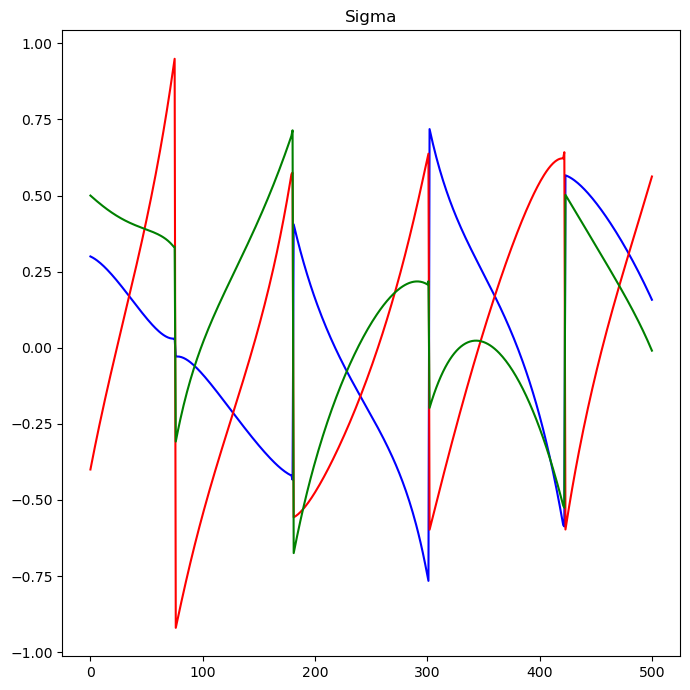

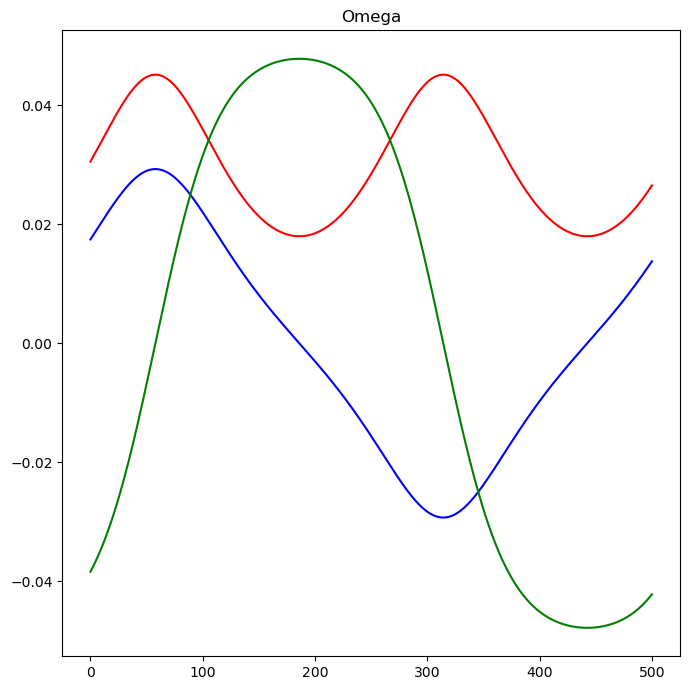

[ 0.15771734  0.56261567 -0.0094879 ]


In [230]:
#Simulation with 0 control torque
simulate(0, 500, 1, Xdot, 0)

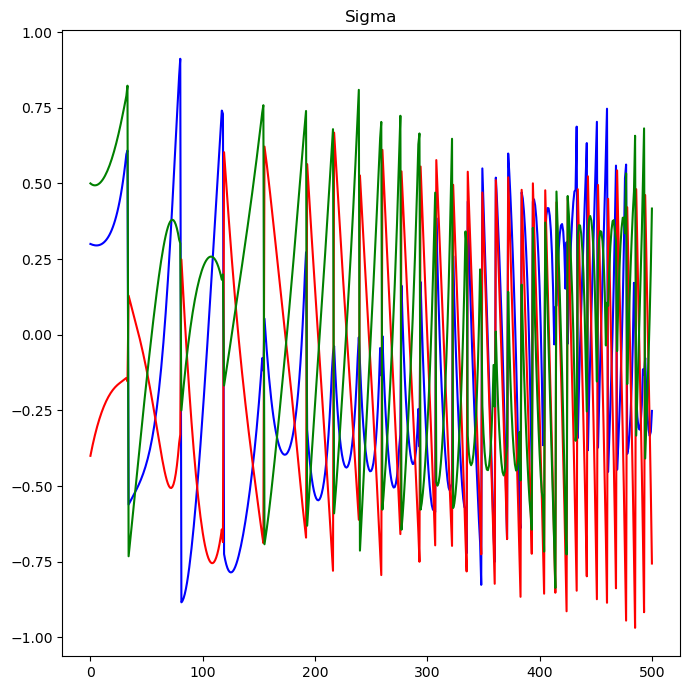

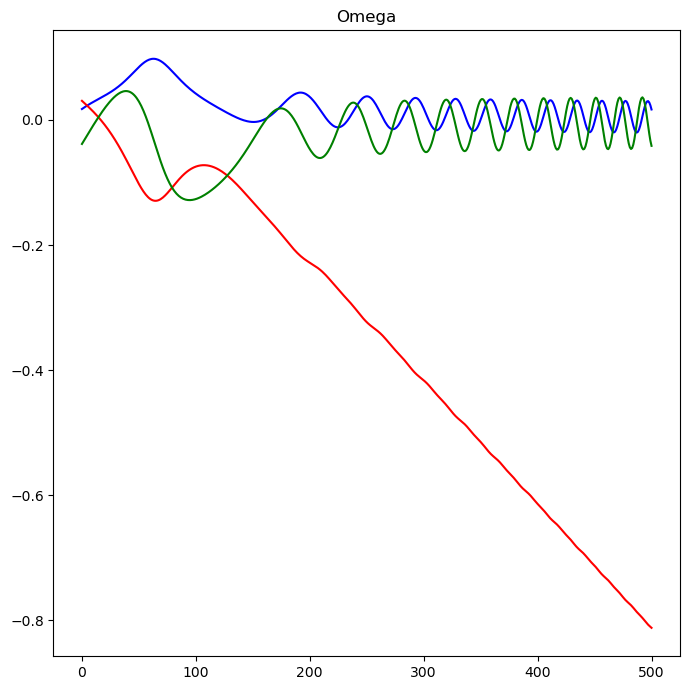

[-0.25165666 -0.75578838  0.41694486]


In [231]:
#Simulation with constant control torque
simulate(0, 500, 1, Xdot, 1)

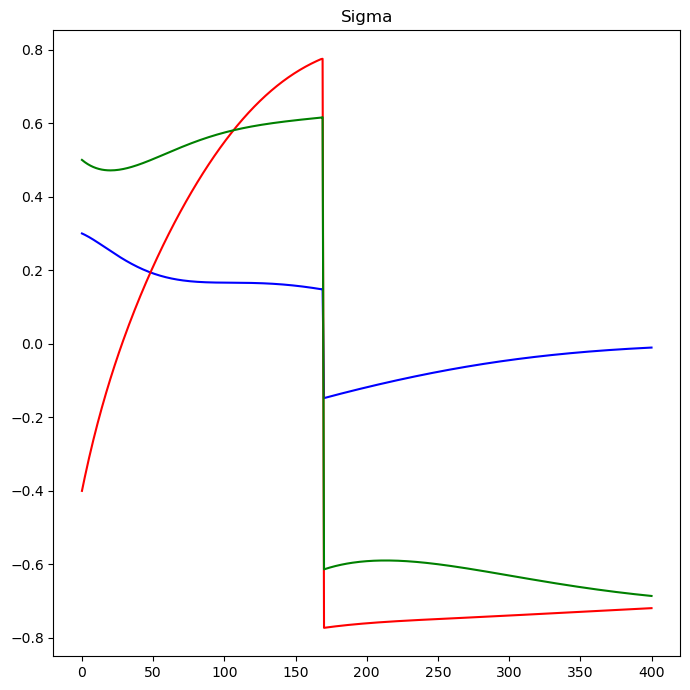

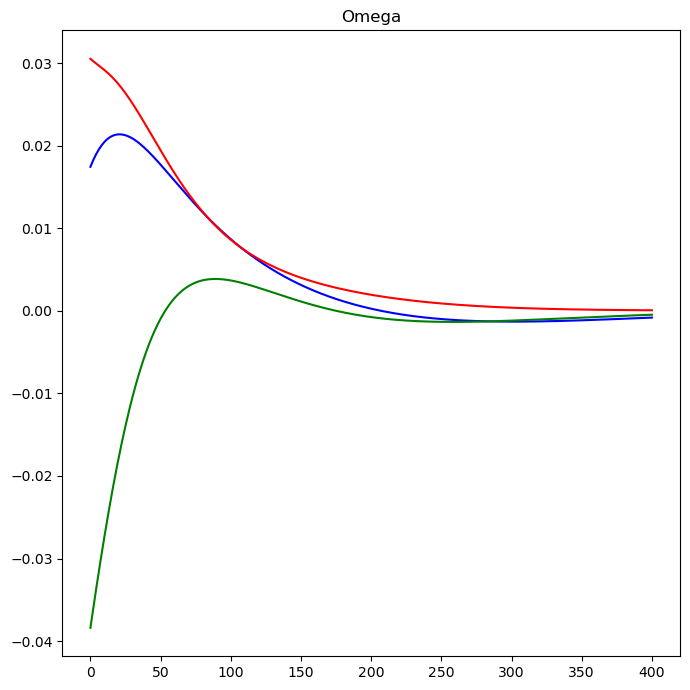

[-0.01030301 -0.71889599 -0.68575177]


In [232]:
#Simulation of sun-pointing mode
simulate(0, 400, 1, Xdot, 2)

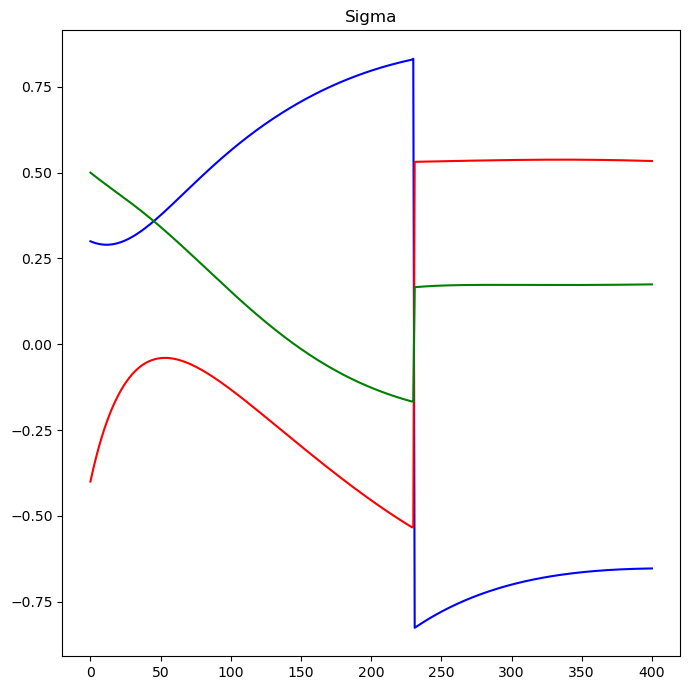

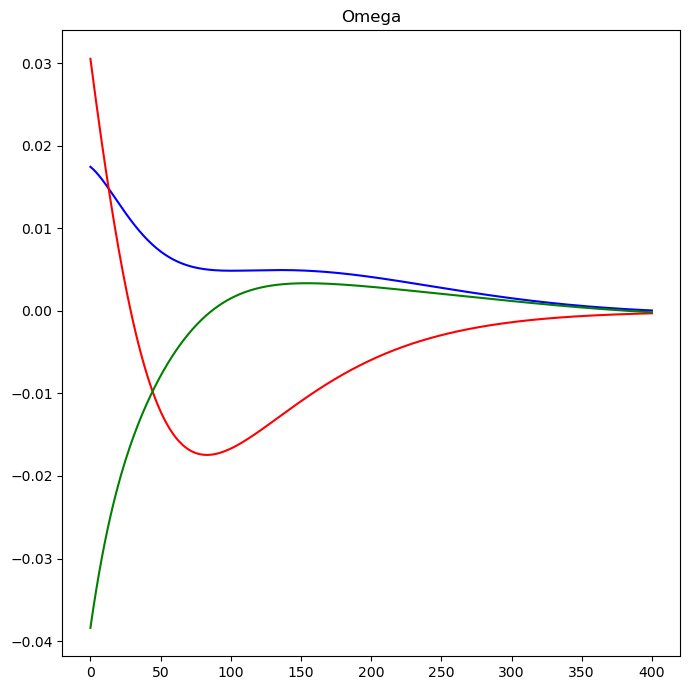

[-0.65293639  0.53373223  0.17447179]


In [233]:
#Simulation of nadir-pointing mode
simulate(0, 400, 1, Xdot, 3)

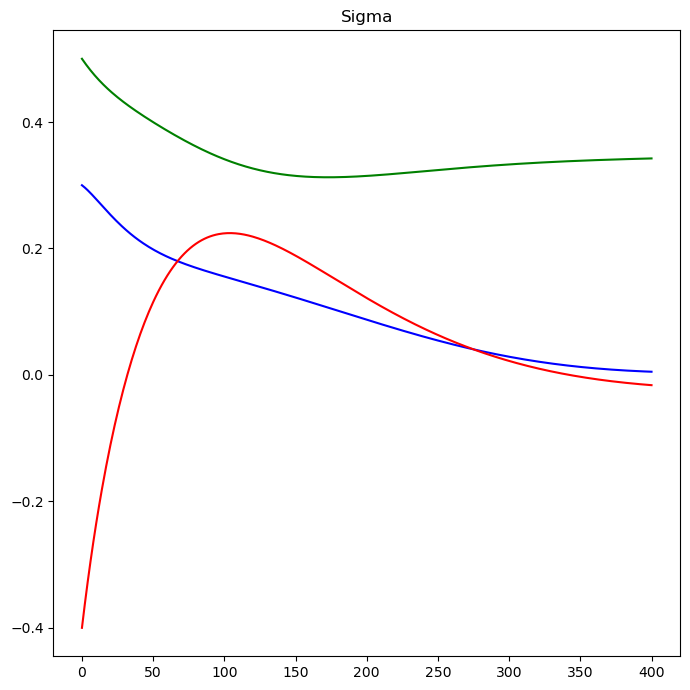

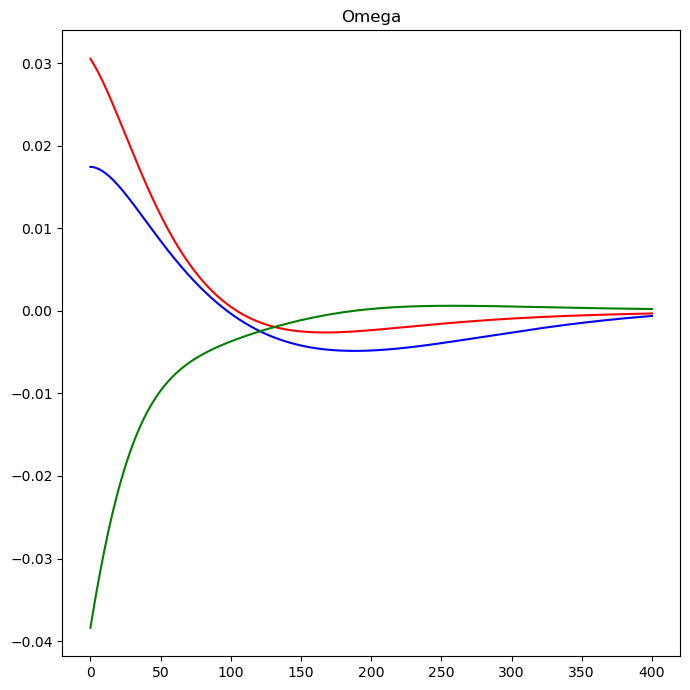

[ 0.00504044 -0.01620903  0.34240423]


In [234]:
#Simulation of communication mode
simulate(0, 400, 1, Xdot, 4)

In [249]:
def compute_mode(t):
    """Computes mission mode as a function of time"""

    global mission_mode
    sigma_LMO = 20*np.pi/180
    i_LMO = 30*np.pi/180
    theta_LMO = (60*np.pi/180) + np.sqrt(mu_mars/r_LMO**3)*t


    EA313_LMO = np.array([sigma_LMO, i_LMO, theta_LMO])

    r_sat = orbitSimulator(r_LMO, EA313_LMO)[0]

    if r_sat[1] > 0:
        mission_mode = 'sun'

    else:
        sigma_GMO = 0
        i_GMO = 0
        theta_GMO = (250*np.pi/180) + np.sqrt(mu_mars/r_GMO**3)*t

        EA313_GMO = np.array([sigma_GMO, i_GMO, theta_GMO])
        r_commsat = orbitSimulator(r_GMO, EA313_GMO)[0]

        r_sat_cap = r_sat/np.linalg.norm(r_sat)
        r_commsat_cap = r_commsat/np.linalg.norm(r_commsat)

        cosine = np.dot(r_sat_cap, r_commsat_cap)

        if (cosine < 1 and cosine > math.cos(35*np.pi/180)):
            mission_mode = 'comm'

        else:
            mission_mode = 'nadir'

    print(mission_mode)

In [250]:
compute_mode(0)
compute_mode(300)
compute_mode(2100)
compute_mode(3400)
compute_mode(4400)
compute_mode(5600)

sun
sun
nadir
comm
nadir
sun
